In [4]:
import pandas as pd
from data_processing import Clean, Remove, balance, NoiseGenerator
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

df = pd.read_csv('data/train.csv', low_memory=False)#[['title', 'برند و تیپ']]
# df.rename(columns={'برند و تیپ': 'model'}, inplace=True)

df = df[df.model.notna() & df.title.notna()]
df = Remove(df, field_name='title').data
df = Clean(df, field_name='title').normalize_data()
df = Remove(df, field_name='model').data
models_clean = Clean(pd.DataFrame(df.model.unique(), columns=['model']), field_name='model').normalize_data()
models_clean = {k: v for k, v in zip(df.model.unique(), models_clean.model.unique())}
df['model'] = df['model'].apply(lambda x: models_clean[x])
df = df[df.model.notna() & df.title.notna()]
le = LabelEncoder()
df['label'] = le.fit_transform(df['model'])
words = NoiseGenerator.get_noisy_words(df['title'], df['model'])
df = NoiseGenerator.generate_noisy_df(df, add_noise_to='title', group_by='model', noise=words, limit=1000, range_samples=(750, 1000))
df = balance(df, group_by='model', range_samples=(750, 1000))


Number of rows after removing English instance: 136542
Number of rows after removing invalid instance: 134784
Number of rows after removing company ads: 129723


100%|██████████| 129723/129723 [00:12<00:00, 10137.65it/s]


Number of rows after removing English instance: 129723
Number of rows after removing invalid instance: 129723
Number of rows after removing company ads: 129723


100%|██████████| 975/975 [00:27<00:00, 35.96it/s]


In [6]:
test = pd.read_csv('data/test.csv', low_memory=False)#[['title', 'برند و تیپ']]
# df.rename(columns={'برند و تیپ': 'model'}, inplace=True)

test = test[test.model.notna() & test.title.notna()]
test = Remove(test, field_name='title').data
test = Clean(test, field_name='title').normalize_data()
test = Remove(test, field_name='model').data
models_clean = Clean(pd.DataFrame(test.model.unique(), columns=['model']), field_name='model').normalize_data()
models_clean = {k: v for k, v in zip(test.model.unique(), models_clean.model.unique())}
test['model'] = test['model'].apply(lambda x: models_clean[x])
test = test[test.model.notna() & test.title.notna()]
test = test[test.model.isin(le.classes_)]
test['label'] = le.transform(test['model'])
# words = NoiseGenerator.get_noisy_words(df['title'], df['model'])
# df = NoiseGenerator.generate_noisy_df(df, add_noise_to='title', group_by='model', noise=words, limit=1000, range_samples=(750, 1000))
# df = balance(df, group_by='model', range_samples=(750, 1000))


Number of rows after removing English instance: 34125
Number of rows after removing invalid instance: 33708
Number of rows after removing company ads: 32437


100%|██████████| 32437/32437 [00:03<00:00, 9998.41it/s] 


Number of rows after removing English instance: 32437
Number of rows after removing invalid instance: 32437
Number of rows after removing company ads: 32437


100%|██████████| 802/802 [00:00<00:00, 11640.36it/s]


In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(df['title'])
tfidf_matrix_test = tfidf_vectorizer.transform(test['title'])
# vectorizer = CountVectorizer()
# bow_matrix = vectorizer.fit_transform(df['title'])

# hashing_vectorizer = HashingVectorizer()
# hashing_matrix = hashing_vectorizer.fit_transform(df['title'])

# one_hot_encoder = CountVectorizer(binary=True)
# one_hot_matrix = one_hot_encoder.fit_transform(df['title'])

# label_encoder = LabelEncoder()
# integer_encoded = label_encoder.fit_transform(df['title'])
# onehot_encoder = OneHotEncoder(sparse=False)
# integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
# onehot_matrix = onehot_encoder.fit_transform(integer_encoded)

# scaler = StandardScaler(with_mean=False)
# tfidf_scaled = scaler.fit_transform(tfidf_matrix)
 
# normalizer = Normalizer()
# tfidf_normalized = normalizer.fit_transform(tfidf_matrix)

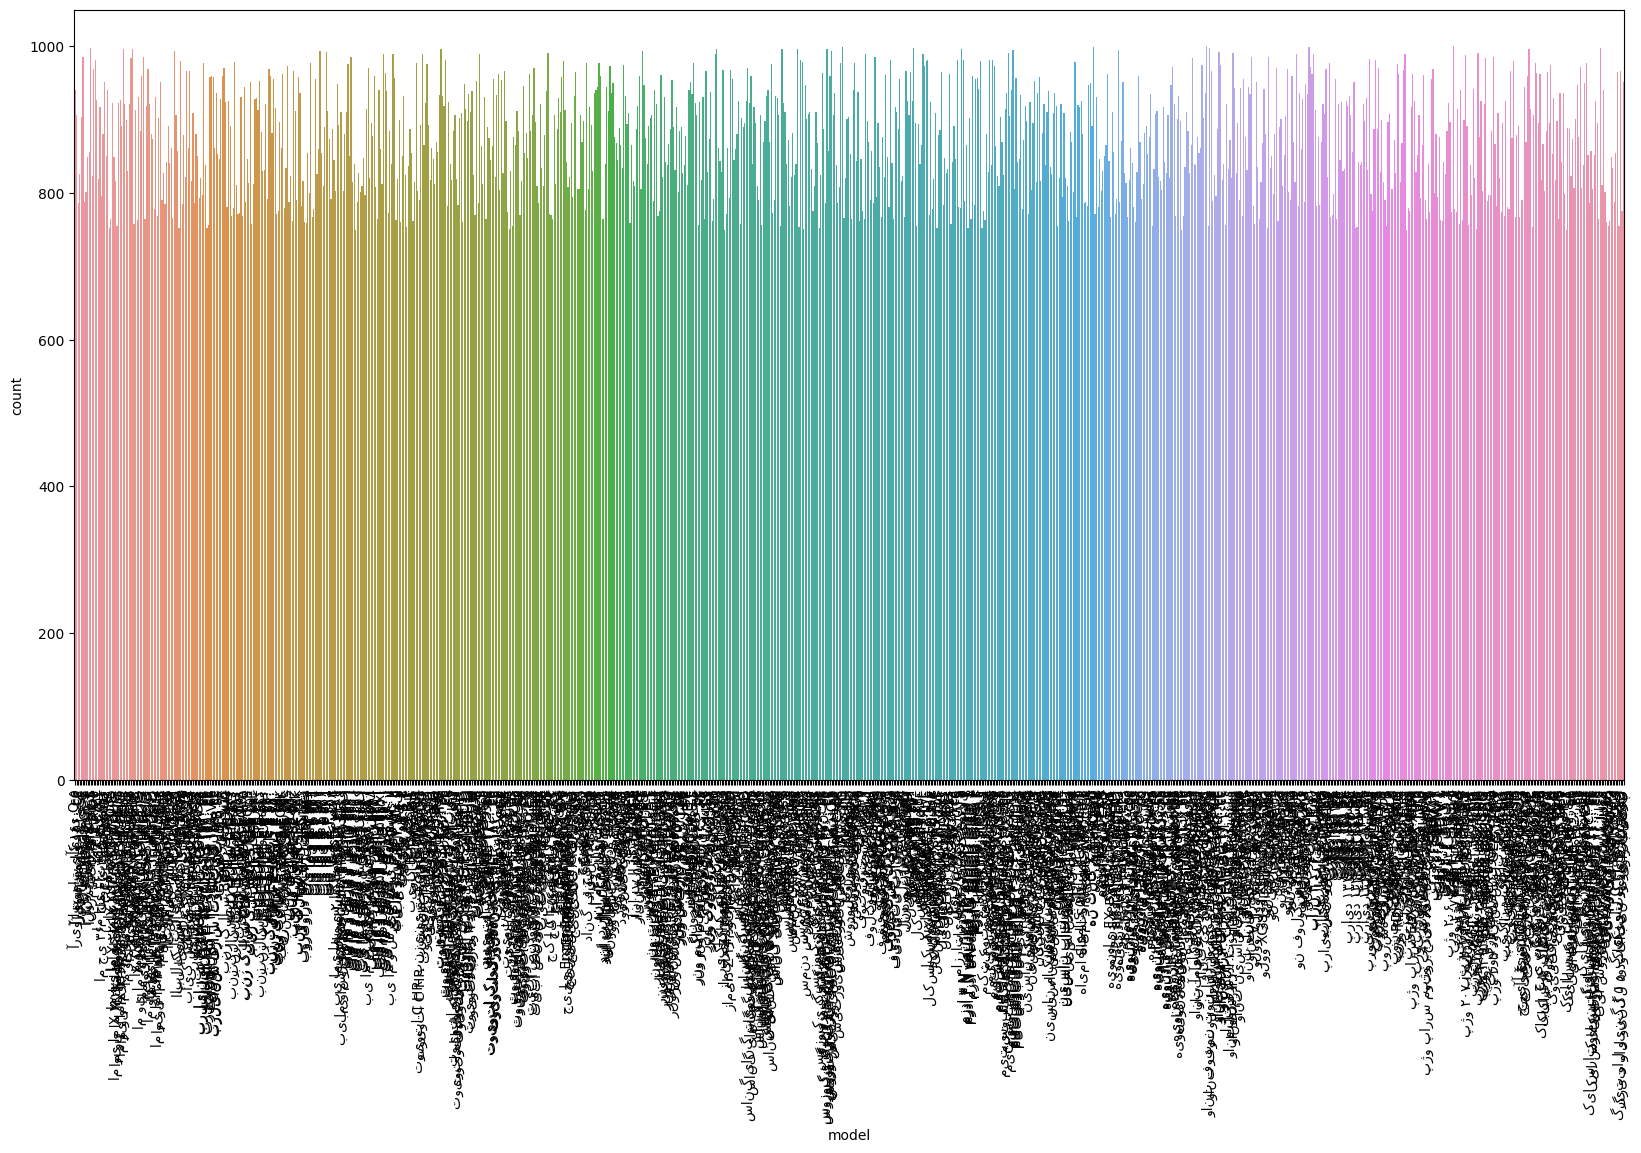

In [8]:
# Plot the frequency of the models
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(20, 10))
sns.countplot(x='model', data=df)
plt.xticks(rotation=90)
plt.show()


In [3]:
X_train, X_test, y_train, y_test = train_test_split(tfidf_matrix, df['label'], test_size=0.2, random_state=42, shuffle=True, stratify=df['label'])
# X_train, y_train = tfidf_matrix, df_balanced['label']

In [8]:
from sklearn.linear_model import LogisticRegression
 
logistic_model = LogisticRegression(n_jobs=-1, verbose=1)
logistic_model.fit(X_train, y_train)

y_pred = logistic_model.predict(X_test)
print(accuracy_score(y_test, y_pred))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


KeyboardInterrupt: 

In [4]:
# SVM One vs One
from sklearn.svm import SVC
from sklearn.multiclass import OneVsOneClassifier

svm_model = SVC(verbose=1)
svm_model.fit(X_train, y_train)

y_pred = svm_model.predict(X_test)
print(accuracy_score(y_test, y_pred))

Training:   0%|          | 0/720257 [00:00<?, ?it/s]

In [9]:
sgd_clf = SGDClassifier(random_state=42, n_jobs=-1, verbose=1)
sgd_clf.fit(tfidf_matrix, df['label'])

y_pred = sgd_clf.predict(tfidf_matrix_test)
print(accuracy_score(test['label'], y_pred))

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


-- Epoch 1
-- Epoch 1
-- Epoch 1
-- Epoch 1
-- Epoch 1
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 0.86, NNZs: 2421, Bias: -1.183886, T: 871530, Avg. loss: 0.001833
Total training time: 0.16 seconds.
-- Epoch 2
Norm: 3.96, NNZs: 3091, Bias: -1.004406, T: 871530, Avg. loss: 0.000418
Total training time: 0.17 seconds.
-- Epoch 2
Norm: 3.51, NNZs: 2298, Bias: -1.058088, T: 871530, Avg. loss: 0.000900
Total training time: 0.18 seconds.
-- Epoch 2
Norm: 1.58, NNZs: 2313, Bias: -1.234532, T: 871530, Avg. loss: 0.001703
Total training time: 0.17 seconds.
-- Epoch 2
Norm: 2.96, NNZs: 2724, Bias: -1.230128, T: 871530, Avg. loss: 0.000881
Total training time: 0.17 seconds.
-- Epoch 2
Norm: 0.70, NNZs: 2269, Bias: -1.023336, T: 871530, Avg. loss: 0.001800
Total training time: 0.18 seconds.
-- Epoch 2
Norm: 3.89, NNZs: 2519, Bias: -1.064602, T: 871530, Avg. loss: 0.000440
Total training time: 0.19 seconds.
-- Epoch 2
Norm: 1.99, NNZs: 2547, Bias: -1.308958, T: 871530, Avg. loss: 0.001743
Total training

[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    5.6s


Norm: 1.09, NNZs: 2173, Bias: -1.257050, T: 5229180, Avg. loss: 0.001650
Total training time: 1.21 seconds.
Convergence after 6 epochs took 1.21 seconds
-- Epoch 1
Norm: 0.71, NNZs: 2659, Bias: -1.176333, T: 5229180, Avg. loss: 0.002101
Total training time: 1.20 seconds.
Convergence after 6 epochs took 1.20 seconds
-- Epoch 1
Norm: 1.37, NNZs: 2441, Bias: -1.252993, T: 871530, Avg. loss: 0.002191
Total training time: 0.19 seconds.
-- Epoch 2
Norm: 1.16, NNZs: 2077, Bias: -1.231457, T: 871530, Avg. loss: 0.001687
Total training time: 0.19 seconds.
-- Epoch 2
Norm: 1.42, NNZs: 2431, Bias: -1.259675, T: 871530, Avg. loss: 0.002169
Total training time: 0.29 seconds.
-- Epoch 2
Norm: 0.61, NNZs: 2171, Bias: -1.174071, T: 1743060, Avg. loss: 0.001769
Total training time: 0.35 seconds.
-- Epoch 3
Norm: 0.96, NNZs: 2382, Bias: -1.281864, T: 1743060, Avg. loss: 0.002165
Total training time: 0.38 seconds.
-- Epoch 3
Norm: 0.82, NNZs: 2394, Bias: -1.221344, T: 1743060, Avg. loss: 0.002048
Total t

[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   25.9s


Norm: 3.56, NNZs: 2791, Bias: -1.523777, T: 871530, Avg. loss: 0.000420
Total training time: 0.20 seconds.
-- Epoch 2
Norm: 2.09, NNZs: 2535, Bias: -1.388760, T: 1743060, Avg. loss: 0.001405
Total training time: 0.40 seconds.
-- Epoch 3
Norm: 2.95, NNZs: 3059, Bias: -1.426464, T: 2614590, Avg. loss: 0.000874
Total training time: 0.64 seconds.
-- Epoch 4
Norm: 2.55, NNZs: 2460, Bias: -1.633975, T: 1743060, Avg. loss: 0.001163
Total training time: 0.37 seconds.
-- Epoch 3
Norm: 2.58, NNZs: 2827, Bias: -1.434192, T: 1743060, Avg. loss: 0.001546
Total training time: 0.41 seconds.
-- Epoch 3
Norm: 2.64, NNZs: 2693, Bias: -1.161648, T: 2614590, Avg. loss: 0.001268
Total training time: 0.60 seconds.
-- Epoch 4
Norm: 1.60, NNZs: 2660, Bias: -1.220256, T: 3486120, Avg. loss: 0.001638
Total training time: 0.71 seconds.
-- Epoch 5
Norm: 1.60, NNZs: 2983, Bias: -1.201289, T: 2614590, Avg. loss: 0.001874
Total training time: 0.57 seconds.
-- Epoch 4
Norm: 3.53, NNZs: 2848, Bias: -1.529816, T: 17430

[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   59.3s


Norm: 3.41, NNZs: 2806, Bias: -1.125845, T: 2614590, Avg. loss: 0.000972
Total training time: 0.59 seconds.
-- Epoch 4
Norm: 1.70, NNZs: 2895, Bias: -1.236988, T: 1743060, Avg. loss: 0.001844
Total training time: 0.34 seconds.
-- Epoch 3
Norm: 3.33, NNZs: 2556, Bias: -1.200985, T: 2614590, Avg. loss: 0.000862
Total training time: 0.52 seconds.
-- Epoch 4
Norm: 2.04, NNZs: 2910, Bias: -1.247041, T: 871530, Avg. loss: 0.001467
Total training time: 0.14 seconds.
-- Epoch 2
Norm: 2.34, NNZs: 3042, Bias: -1.353488, T: 4357650, Avg. loss: 0.001684
Total training time: 0.85 seconds.
-- Epoch 6
Norm: 1.26, NNZs: 2573, Bias: -1.188382, T: 1743060, Avg. loss: 0.001930
Total training time: 0.35 seconds.
-- Epoch 3
Norm: 4.13, NNZs: 3052, Bias: -1.200402, T: 3486120, Avg. loss: 0.000439
Total training time: 0.64 seconds.
-- Epoch 5
Norm: 2.96, NNZs: 2454, Bias: -1.356568, T: 871530, Avg. loss: 0.000927
Total training time: 0.19 seconds.
-- Epoch 2
Norm: 3.40, NNZs: 2846, Bias: -1.121355, T: 348612

[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  1.8min


Norm: 1.49, NNZs: 2376, Bias: -1.246110, T: 871530, Avg. loss: 0.001785
Total training time: 0.16 seconds.
-- Epoch 2
Norm: 2.01, NNZs: 2928, Bias: -1.292748, T: 3486120, Avg. loss: 0.001425
Total training time: 0.78 seconds.
-- Epoch 5
Norm: 3.14, NNZs: 3451, Bias: -1.281078, T: 3486120, Avg. loss: 0.001195
Total training time: 0.65 seconds.
-- Epoch 5
Norm: 0.74, NNZs: 2748, Bias: -1.155262, T: 2614590, Avg. loss: 0.002256
Total training time: 0.50 seconds.
-- Epoch 4
Norm: 2.23, NNZs: 2665, Bias: -1.166558, T: 1743060, Avg. loss: 0.001699
Total training time: 0.38 seconds.
-- Epoch 3
Norm: 0.59, NNZs: 2600, Bias: -1.112126, T: 2614590, Avg. loss: 0.001783
Total training time: 0.55 seconds.
-- Epoch 4
Norm: 0.60, NNZs: 2642, Bias: -1.103756, T: 3486120, Avg. loss: 0.001859
Total training time: 0.67 seconds.
-- Epoch 5
Norm: 1.84, NNZs: 2947, Bias: -1.344084, T: 3486120, Avg. loss: 0.001674
Total training time: 0.72 seconds.
-- Epoch 5
Norm: 1.50, NNZs: 2536, Bias: -1.243498, T: 17430

[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:  2.2min finished


0.7923829511434832


In [11]:
from sklearn.metrics import f1_score

f1_score(test['label'], y_pred, average='weighted')

0.8140915415922068

In [9]:
from sklearn.ensemble import RandomForestClassifier

# weight = df['label'].value_counts().sort_values(ascending=False).values
forest_clf = RandomForestClassifier(random_state=42, verbose=1, n_jobs=-1, n_estimators=50)
forest_clf.fit(X_train, y_train)

y_pred = forest_clf.predict(X_test)
print(accuracy_score(y_test, y_pred))

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


KeyboardInterrupt: 

In [12]:
# Navie Bayes
from sklearn.naive_bayes import MultinomialNB
 
nb_model = MultinomialNB()
nb_model.fit(X_train, y_train)
 
y_pred = nb_model.predict(X_test)
print(accuracy_score(y_test, y_pred))

0.9221789883268483
